# SENTIMENT ANALYSIS OF TWEETS

# Twitter sentiment analysis related to the separation of illegal immigrant families in the United States. 
Related search criteria:  
    - FamiliesBelongTogether 
    - Immigration 
    - ChildrenInCages 
    - KeepFamiliesTogether New heading

In [2]:
import tweepy
import pandas as pd
import numpy as np

In [3]:
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import os
import sys
from tweepy import OAuthHandler
from tweepy import API
from tweepy import Cursor

# Objective
    - Investigate the public reaction following a major change in the immigration policy
    - Classify the tweet based on the topics and analyse how the sentiments are for these topics with respect to immigration
    - Analyse based on the date and time


# Pseudocode
1) Data Collection from twitter
    - Initialize Twitter Authentication & set up API client - using “tweepy” package 
    - Query for tweets based on 'FamiliesBelongTogether OR immigration OR ChildrenInCages OR KeepFamiliesTogether’
    - Search for tweets for the dates Jun23 -26
    - This resulted in approximately 60K tweets
    - The tweets are in json format.
    - Create Pandas dataframe from the json files.
2) Text Processing/ Cleanup of the text data
    - Get relevant information from the dictionary data like entities, user
    - Remove URLs, special characters from the text
3) Get frequency of the hashtags  
4) Tokenization
    - Tokenize 
    - Get the frequency of the commonly occuring words using NLTK Tweet
5) Derive wordcloud for commonly occuring words
6) Perform Vader Sentiment analysis
    - Categorize the sentiments based on vader compund sentiment
    - Find the commonly occuring words for positive, negative and neutral sentiments
7) Categorize the tweets
8) Derive other insights like who tweeted more, which tweet was favorited more, retweeted more, tweets locations etc.

## 1) Data Collection from Twitter

In [4]:
def twitter_initialize():
    """ Initialize Twitter Authentication & set up API client """
    try:
        consumer_key = os.environ['TWITTER_CONSUMER_KEY']
        consumer_secret = os.environ['TWITTER_CONSUMER_SECRET']
        access_token = os.environ['TWITTER_ACCESS_TOKEN']
        access_secret = os.environ['TWITTER_ACCESS_SECRET']
    except KeyError:
        sys.stderr.write("TWITTER_* environment variables not set\n")
        sys.exit(1)
    auth = OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_secret)
    
    ## Setup twitter API Client ##
    client = API(auth, wait_on_rate_limit=True)
    return client

In [5]:
api = twitter_initialize()

### 1.1) Tweet search for 4 search queries 
'FamiliesBelongTogether OR immigration OR ChildrenInCages OR KeepFamiliesTogether'

In [6]:
query = 'FamiliesBelongTogether OR immigration OR ChildrenInCages OR KeepFamiliesTogether'

In [7]:
fname1 = "tweetssearchjun26.jsonl"

In [12]:
with open(fname1, 'w') as f:
    for tweet in Cursor(api.search, q=query + " -rt", include_retweets=False, since='2018-06-26', until = '2018-06-27').items(10000):
        f.write(json.dumps(tweet._json)+"\n")

In [19]:
fname2 = "tweetssearchjun23.jsonl"

In [20]:
with open(fname2, 'w') as f:
    for tweet in Cursor(api.search, q=query + " -rt", include_retweets=False, since='2018-06-23', until = '2018-06-24').items(10000):
        f.write(json.dumps(tweet._json)+"\n")

In [21]:
fname3 = "tweetssearchjun24.jsonl"

In [23]:
with open(fname3, 'w') as f:
    for tweet in Cursor(api.search, q=query + " -rt", include_retweets=False, since='2018-06-24', until = '2018-06-25').items(20000):
        f.write(json.dumps(tweet._json)+"\n")

In [24]:
fname4 = "tweetssearchjun25.jsonl"

In [25]:
with open(fname4, 'w') as f:
    for tweet in Cursor(api.search, q=query + " -rt", include_retweets=False, since='2018-06-25', until = '2018-06-26').items(20000):
        f.write(json.dumps(tweet._json)+"\n")

### 1.2) Create Dataframes from json files from twitter

I'm going to create individual dataframes from different json files. Merging them to a single dataframe resulted in pandas series and didnt retain the data structure. Create indiv dataframes for different tweet files 23, 24, 25, 26

In [5]:
import pandas as pd
tweets_df23 = pd.read_json("tweetssearchjun23.jsonl", orient = 'records', lines = True)

In [15]:
tweets_df23['withheld_in_countries']= np.NaN

In [6]:
tweets_df24 = pd.read_json("tweetssearchjun24.jsonl", orient = 'records', lines = True)
tweets_df25 = pd.read_json("tweetssearchjun25.jsonl", orient = 'records', lines = True)
tweets_df26 = pd.read_json("tweetssearchjun26.jsonl", orient = 'records', lines = True)

## 2) Text Data Processing

### 2.1) Get relevant information from the dictionary data like entities, user
JSON columns with embedded dictionaries are
    entities
    metadata
    user

#### 2.1.1) Column USER with dictionary keys & Values. Create new columns
- create new columns based on the data required from the dictionary

In [33]:
tweets_df23.user[1001].keys()

dict_keys(['id', 'id_str', 'name', 'screen_name', 'location', 'description', 'url', 'entities', 'protected', 'followers_count', 'friends_count', 'listed_count', 'created_at', 'favourites_count', 'utc_offset', 'time_zone', 'geo_enabled', 'verified', 'statuses_count', 'lang', 'contributors_enabled', 'is_translator', 'is_translation_enabled', 'profile_background_color', 'profile_background_image_url', 'profile_background_image_url_https', 'profile_background_tile', 'profile_image_url', 'profile_image_url_https', 'profile_link_color', 'profile_sidebar_border_color', 'profile_sidebar_fill_color', 'profile_text_color', 'profile_use_background_image', 'has_extended_profile', 'default_profile', 'default_profile_image', 'following', 'follow_request_sent', 'notifications', 'translator_type'])

In [35]:
tweets_df23.user[1001].values()

dict_values([122058410, '122058410', 'Carmen Mannella', 'carmmann', 'United States', 'Husband, father, grandfather, scientist, Bills Mafia, floats like a butterfly, stings like a butterfly', None, {'description': {'urls': []}}, False, 23, 39, 0, 'Thu Mar 11 13:11:17 +0000 2010', 5071, None, None, True, False, 3208, 'en', False, False, False, 'C0DEED', 'http://abs.twimg.com/images/themes/theme1/bg.png', 'https://abs.twimg.com/images/themes/theme1/bg.png', False, 'http://pbs.twimg.com/profile_images/893136694416859137/PEMKIhgL_normal.jpg', 'https://pbs.twimg.com/profile_images/893136694416859137/PEMKIhgL_normal.jpg', '1DA1F2', 'C0DEED', 'DDEEF6', '333333', True, False, True, False, False, False, False, 'none'])

In [36]:
onlykeys = ['id_str', 'name', 'screen_name', 'location', 'description', 'followers_count', 'following', 'verified']

In [37]:
for i in range(len(onlykeys)):
    tweets_df23[onlykeys[i]] = [x.get(onlykeys[i]) for x in tweets_df23.user]
    tweets_df24[onlykeys[i]] = [x.get(onlykeys[i]) for x in tweets_df24.user]
    tweets_df25[onlykeys[i]] = [x.get(onlykeys[i]) for x in tweets_df25.user]
    tweets_df26[onlykeys[i]] = [x.get(onlykeys[i]) for x in tweets_df26.user]    

#### 2.1.2) Column entities with dictionary keys & Values

In [38]:
tweets_df26.entities[0].keys()

dict_keys(['hashtags', 'symbols', 'user_mentions', 'urls', 'media'])

In [40]:
tweets_df26.entities[555].values()

dict_values([[], [], [{'screen_name': 'tedlieu', 'name': 'Ted Lieu', 'id': 21059255, 'id_str': '21059255', 'indices': [5, 13]}], [{'url': 'https://t.co/CCBA1Ke7Zn', 'expanded_url': 'https://twitter.com/tedlieu/status/1011044101804851201', 'display_url': 'twitter.com/tedlieu/status…', 'indices': [106, 129]}]])

#### 2.1.3) Column metadata with dictionary keys & Values

In [41]:
tweets_df26.metadata[0].keys()

dict_keys(['iso_language_code', 'result_type'])

In [42]:
tweets_df26.metadata[0].values()

dict_values(['en', 'recent'])

In [43]:
tweets_df26.metadata.head(2)

0    {'iso_language_code': 'en', 'result_type': 're...
1    {'iso_language_code': 'en', 'result_type': 're...
Name: metadata, dtype: object

#### 2.1.4) Drop the columns that are not needed

In [47]:
tweets_df23.drop(['contributors', 'coordinates', 'metadata', 'user', 'geo', 'extended_entities', 'quoted_status', 'quoted_status_id', 'quoted_status_id_str'], axis=1, inplace=True)
tweets_df24.drop(['contributors', 'coordinates', 'metadata', 'user', 'geo', 'extended_entities', 'quoted_status', 'quoted_status_id', 'quoted_status_id_str'], axis=1, inplace=True)
tweets_df25.drop(['contributors', 'coordinates', 'metadata', 'user', 'geo', 'extended_entities', 'quoted_status', 'quoted_status_id', 'quoted_status_id_str'], axis=1, inplace=True)
tweets_df26.drop(['contributors', 'coordinates', 'metadata', 'user', 'geo', 'extended_entities', 'quoted_status', 'quoted_status_id', 'quoted_status_id_str'], axis=1, inplace=True)

In [48]:
tweets_df23.shape, tweets_df24.shape, tweets_df25.shape, tweets_df26.shape

((10000, 28), (20000, 28), (20000, 28), (10000, 28))

In [177]:
tweets_df.entities[0].keys()

Int64Index([0, 0, 0, 0], dtype='int64')

In [178]:
tweets_df24.entities[0].keys()

dict_keys(['hashtags', 'symbols', 'user_mentions', 'urls'])

### 2.2) Cleanup of Text Data 
Remove URLs, special characters from the text

#### 2.2.1) Get text data from anchor tags

In [72]:
from bs4 import BeautifulSoup

In [84]:
tweets_df23.loc[:,'source'][1]

'Twitter for iPhone'

In [83]:
tweets_df23['source'] = [BeautifulSoup(text, "lxml").get_text() for text in tweets_df23['source']] 

In [85]:
tweets_df24['source'] = [BeautifulSoup(text, "lxml").get_text() for text in tweets_df24['source']] 
tweets_df25['source'] = [BeautifulSoup(text, "lxml").get_text() for text in tweets_df25['source']] 
tweets_df26['source'] = [BeautifulSoup(text, "lxml").get_text() for text in tweets_df26['source']] 

In [87]:
tweets_df26.loc[:,'source'][1000]

'Twitter Web Client'

In [618]:
tweets_df.to_csv('tweetslistjun.csv')

D:\Anaconda3\lib\json\encoder.py:199: DeprecationWarning:

Interpreting naive datetime as local 2018-06-28 18:52:46.964239. Please add timezone info to timestamps.



#### 2.2.2) Remove user names with @

In [93]:
import re

In [94]:
tweets_df23['cleaned_text'] = tweets_df23['text']
tweets_df24['cleaned_text'] = tweets_df24['text']
tweets_df25['cleaned_text'] = tweets_df25['text']
tweets_df26['cleaned_text'] = tweets_df26['text']

In [659]:
tweets_df.loc[:,'cleaned_text'].replace(re.compile(r"@[^\s]+[\s]?"), "", inplace=True)

D:\Anaconda3\lib\json\encoder.py:199: DeprecationWarning:

Interpreting naive datetime as local 2018-06-28 20:53:03.724263. Please add timezone info to timestamps.



#### Remove numbers

In [174]:
#tweets_df.loc[:,'cleaned_text'].replace(re.compile(r"\s?[0-9]+\.?[0-9]*"), "", inplace=True)

#### 2.2.3) Remove URLs

for i in range(len(tweets_df23['cleaned_text'])):
    tweets_df23['cleaned_text'][i] = " ".join([word for word in tweets_df23['cleaned_text'][i].split()
                                if 'http' not in word and '@' not in word and '<' not in word])

In [165]:
tweets_df23['cleaned_text'] = tweets_df23['text'].str.partition('http')[0]
tweets_df24['cleaned_text'] = tweets_df24['text'].str.partition('http')[0]
tweets_df25['cleaned_text'] = tweets_df25['text'].str.partition('http')[0]
tweets_df26['cleaned_text'] = tweets_df26['text'].str.partition('http')[0]

In [167]:
tweets_df23[['cleaned_text', 'text']].head(3)

cleaned_text  \
0  @RepGraceMeng @realDonaldTrump Do your job. Se...   
1  This goes beyond party lines.  Separating fami...   
2  Analysis | The bottomless vulgarity of Trump’s...   

                                                text  
0  @RepGraceMeng @realDonaldTrump Do your job. Se...  
1  This goes beyond party lines.  Separating fami...  
2  Analysis | The bottomless vulgarity of Trump’s...

In [168]:
tweets_df23['cleaned_text'][1], tweets_df25['cleaned_text'][402]

('This goes beyond party lines.  Separating families betrays our values as Texans, Americans and fellow human beings.… ',
 'I liked a @YouTube video ')

In [103]:
#tweets_df.loc[:'cleaned_text'].replace(re.compile(r"http\S+"), "", inplace=True)
#tweets_df.loc[:'cleaned_text'].replace(re.compile(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*'), "", inplace=True)
#tweets_df.loc[:'cleaned_text'].replace(/(?:https?|ftp):\/\/[\n\S]+/g, '')



#### 2.2.4) Remove special characters

In [169]:
for remove in map(lambda r: re.compile(re.escape(r)), [",", ":", "\"", "=", "&", ";", "%", "$", "#",
                                                                     "@", "%", "^", "*", "(", ")", "{", "}",
                                                                     "[", "]", "|", "/", "\\", ">", "<", "-",
                                                                     "!", "?", ".", "'",
                                                                     "--", "---", "\n"]):
            tweets_df23.loc[:, "cleaned_text"].replace(remove, "", inplace=True)

In [170]:
for remove in map(lambda r: re.compile(re.escape(r)), [",", ":", "\"", "=", "&", ";", "%", "$", "#",
                                                                     "@", "%", "^", "*", "(", ")", "{", "}",
                                                                     "[", "]", "|", "/", "\\", ">", "<", "-",
                                                                     "!", "?", ".", "'",
                                                                     "--", "---", "\n"]):
            tweets_df24.loc[:, "cleaned_text"].replace(remove, "", inplace=True)

In [171]:
for remove in map(lambda r: re.compile(re.escape(r)), [",", ":", "\"", "=", "&", ";", "%", "$", "#",
                                                                     "@", "%", "^", "*", "(", ")", "{", "}",
                                                                     "[", "]", "|", "/", "\\", ">", "<", "-",
                                                                     "!", "?", ".", "'",
                                                                     "--", "---", "\n"]):
            tweets_df25.loc[:, "cleaned_text"].replace(remove, "", inplace=True)

In [172]:
for remove in map(lambda r: re.compile(re.escape(r)), [",", ":", "\"", "=", "&", ";", "%", "$", "#",
                                                                     "@", "%", "^", "*", "(", ")", "{", "}",
                                                                     "[", "]", "|", "/", "\\", ">", "<", "-",
                                                                     "!", "?", ".", "'",
                                                                     "--", "---", "\n"]):
            tweets_df26.loc[:, "cleaned_text"].replace(remove, "", inplace=True)

In [175]:
tweet1 = tweets_df23.copy()
tweet2 = tweets_df24.copy()
tweet3 = tweets_df25.copy()
tweet4 = tweets_df26.copy()

## 3) Hashtag Frequency

In [298]:
tweets_df23['entities'][0]
for i in range(len(onlykeys)):
    tweets_df23[onlykeys[i]] = [x.get(onlykeys[i]) for x in tweets_df23.user]

{'hashtags': [],
 'symbols': [],
 'urls': [],
 'user_mentions': [{'id': 1051127714,
   'id_str': '1051127714',
   'indices': [0, 13],
   'name': 'Grace Meng',
   'screen_name': 'RepGraceMeng'},
  {'id': 25073877,
   'id_str': '25073877',
   'indices': [14, 30],
   'name': 'Donald J. Trump',
   'screen_name': 'realDonaldTrump'}]}

In [181]:
hashtags_tweets23 = []
for ht in tweets_df23['entities']:
    if ht.get('hashtags') != []:
        for i in range(len(ht.get('hashtags'))):
            #print(len(ht.get('hashtags')))
            hashtags_tweets23.append(ht.get('hashtags')[i]['text'])

In [183]:
hashtags_tweets24 = []
for ht in tweets_df24['entities']:
    if ht.get('hashtags') != []:
        for i in range(len(ht.get('hashtags'))):
            #print(len(ht.get('hashtags')))
            hashtags_tweets24.append(ht.get('hashtags')[i]['text'])

In [184]:
hashtags_tweets25 = []
for ht in tweets_df25['entities']:
    if ht.get('hashtags') != []:
        for i in range(len(ht.get('hashtags'))):
            #print(len(ht.get('hashtags')))
            hashtags_tweets25.append(ht.get('hashtags')[i]['text'])

In [185]:
hashtags_tweets26 = []
for ht in tweets_df26['entities']:
    if ht.get('hashtags') != []:
        for i in range(len(ht.get('hashtags'))):
            #print(len(ht.get('hashtags')))
            hashtags_tweets26.append(ht.get('hashtags')[i]['text'])

In [215]:
def count_elements(lst):
    elements = {}
    lst_lower = [ls.lower() for ls in lst]
    for elem in lst_lower:
        if elem in elements.keys():
            elements[elem] +=1
        else:
            elements[elem] = 1
    return elements

In [216]:
hashtags_tweets = hashtags_tweets23 + hashtags_tweets24 + hashtags_tweets25 + hashtags_tweets26
len(hashtags_tweets)

19621

In [217]:
hashtags_cnt = count_elements(hashtags_tweets)

In [222]:
hashtags_df = pd.DataFrame(list(hashtags_cnt.items()),columns=['Hashtag', 'Count'])
hashtags_df = hashtags_df.sort_values(by = 'Count', ascending=False)
hashtags_df[hashtags_df['Count']>150]

Hashtag  Count
4    familiesbelongtogether   2309
0               immigration   1665
21     keepfamiliestogether   1066
29                    trump    489
55          childrenincages    292
85                    تركيا    275
5                      maga    225
27                   resist    214
51     singlestagingareanow    173
113                     gop    151

In [637]:
ht150 = hashtags_df[hashtags_df['Count']>150]

D:\Anaconda3\lib\json\encoder.py:199: DeprecationWarning:

Interpreting naive datetime as local 2018-06-28 19:33:30.334123. Please add timezone info to timestamps.



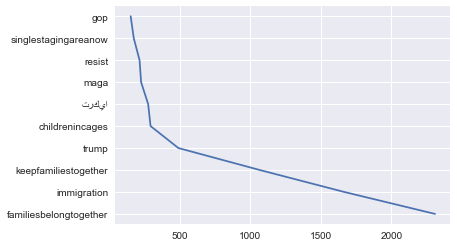

D:\Anaconda3\lib\json\encoder.py:199: DeprecationWarning:

Interpreting naive datetime as local 2018-06-28 19:34:26.414212. Please add timezone info to timestamps.



In [638]:
plt.plot( ht150.Count, ht150.Hashtag)

In [220]:
ht_labels = hashtags_df.Hashtag[hashtags_df['Count']>150]

Text(0,0.5,'Hashtags Count')

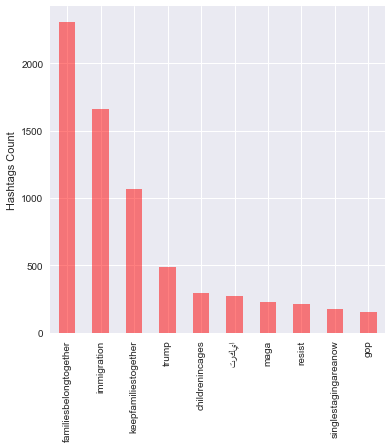

In [221]:
plt.subplots(figsize=(6, 6))
hashtags_df.Count[hashtags_df['Count']>150].plot.bar( align='center', color='red', alpha=0.5)
y_pos = np.arange(len(ht_labels))
plt.xticks(y_pos, ht_labels)
plt.ylabel('Hashtags Count')

### We can see a new tweet with hashtag ##turkey in arabic. Apparently, there are issues around the world when everyone seems to focus only in US. Turkish people are trying to get the attention.

## 4) Merge all dataframes

In [235]:
tweets_dfall = pd.concat([tweets_df23, tweets_df24, tweets_df25, tweets_df26], axis=0).reset_index(drop=True)

In [240]:
tweets_dfall.head(2).T

0  \
created_at                                               2018-06-23 23:59:59   
entities                   {'hashtags': [], 'symbols': [], 'user_mentions...   
favorite_count                                                             5   
favorited                                                              False   
id                                                       1010673855856349184   
id_str                                                    921858853167419397   
in_reply_to_screen_name                                         RepGraceMeng   
in_reply_to_status_id                                            1.01058e+18   
in_reply_to_status_id_str                                        1.01058e+18   
in_reply_to_user_id                                              1.05113e+09   
in_reply_to_user_id_str                                          1.05113e+09   
is_quote_status                                                        False   
lang                                                                      en   
place                                                                   None   
possibly_sensitive                                                       NaN   
retweet_count                                                              0   
retweeted                                                              False   
source                                                   Twitter for Android   
text                       @RepGraceMeng @realDonaldTrump Do your job. Se...   
truncated                                                              False   
withheld_in_countries                                                    NaN   
name                                                                 Tay Tay   
screen_name                                                       taytay3593   
location                                                                       
description                                  Wife, mother, FNP.\n 🇺🇸🚂🚃🚃🚃🇺🇸💎🖥   
followers_count                                                         3406   
following                                                              False   
verified                                                               False   
cleaned_text               RepGraceMeng realDonaldTrump Do your job Secur...   

                                                                           1  
created_at                                               2018-06-23 23:59:58  
entities                   {'hashtags': [], 'symbols': [], 'user_mentions...  
favorite_count                                                           280  
favorited                                                              False  
id                                                       1010673853163540480  
id_str                                                             607721548  
in_reply_to_screen_name                                                 None  
in_reply_to_status_id                                                    NaN  
in_reply_to_status_id_str                                                NaN  
in_reply_to_user_id                                                      NaN  
in_reply_to_user_id_str                                                  NaN  
is_quote_status                                                        False  
lang                                                                      en  
place                                                                   None  
possibly_sensitive                                                         0  
retweet_count                                                             87  
retweeted                                                              False  
source                                                    Twitter for iPhone  
text                       This goes beyond party lines.  Separating fami...  
truncated                                                               True  
withheld_in_cou

In [383]:
tweets_df = tweets_dfall[['id', 'name', 'screen_name', 'location', 'description', 'source',
                         'followers_count', 'retweet_count', 'favorite_count','verified', 'text', 'cleaned_text', 
                          'created_at', 'lang', 'withheld_in_countries', 'possibly_sensitive']]
tweets_df.head().T

0  \
id                                                   1010673855856349184   
name                                                             Tay Tay   
screen_name                                                   taytay3593   
location                                                                   
description                              Wife, mother, FNP.\n 🇺🇸🚂🚃🚃🚃🇺🇸💎🖥   
source                                               Twitter for Android   
followers_count                                                     3406   
retweet_count                                                          0   
favorite_count                                                         5   
verified                                                           False   
text                   @RepGraceMeng @realDonaldTrump Do your job. Se...   
cleaned_text           RepGraceMeng realDonaldTrump Do your job Secur...   
created_at                                           2018-06-23 23:59:59   
lang                                                                  en   
withheld_in_countries                                                NaN   
possibly_sensitive                                                   NaN   

                                                                       1  \
id                                                   1010673853163540480   
name                                                         Lupe Valdez   
screen_name                                                   LupeValdez   
location                                                      Texas, USA   
description            Your next Governor of Texas. Sheriff. Veteran....   
source                                                Twitter for iPhone   
followers_count                                                    16950   
retweet_count                                                         87   
favorite_count                                                       280   
verified                                                            True   
text                   This goes beyond party lines.  Separating fami...   
cleaned_text           This goes beyond party lines  Separating famil...   
created_at                                           2018-06-23 23:59:58   
lang                                                                  en   
withheld_in_countries                                                NaN   
possibly_sensitive                                                     0   

                                                                       2  \
id                                                   1010673848541483010   
name                                                   Joyeta E.Anderson   
screen_name                                                     joyeta_e   
location                                                         Florida   
description            Retired RN, Midwife, Health Visitor, Case Mana...   
source                                                Twitter Web Client   
followers_count                                                     1218   
retweet_count                                                          0   
favorite_count                                                         0   
verified                                                           False   
text                   Analysis | The bottomless vulgarity of Trump’s...   
cleaned_text           Analysis  The bottomless vulgarity of Trump’s ...   
created_at                                           2018-06-23 23:59:57   
lang                                                                  en   
withheld_in_countries                                                NaN   
possibly_sensitive                                                     0   

                                                                       3  \
id                                                   1010673845634830341   
name                                    

## 5) Tweet term frequency using TweetTokenizer

In [384]:
import string
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from collections import Counter

In [385]:
tweet_tokenizer = TweetTokenizer()
punct = list(string.punctuation)
stopwords_list = stopwords.words('english') + punct + ['rt','via','...','…','’','—','—:','“']
tf = Counter()

In [387]:
def process_tweets(x):
    twtokens = process_tweets_tokens(x, tokenizer = tweet_tokenizer, stopwords= stopwords_list)
    return(' '.join(twtokens))

In [388]:
for x in tweets_df.cleaned_text:
    tweet_tokens = process_tweets_tokens(x, tokenizer = tweet_tokenizer, stopwords= stopwords_list)
    tf.update(tweet_tokens)

In [389]:
for tag, count in tf.most_common(20):
    print("{}: {}".format(tag, count))

immigration: 28268
trump: 8660
realdonaldtrump: 4733
illegal: 3945
us: 2847
policy: 2825
border: 2790
people: 2479
children: 2148
familiesbelongtogether: 2078
amp: 2011
immigrants: 1876
president: 1745
want: 1596
trumps: 1590
laws: 1540
like: 1490
law: 1476
one: 1474
democrats: 1387


In [660]:
tweets_df['processed_tweets'] = tweets_df['cleaned_text'].apply(process_tweets)

D:\Anaconda3\lib\json\encoder.py:199: DeprecationWarning:

Interpreting naive datetime as local 2018-06-28 20:53:49.265496. Please add timezone info to timestamps.



In [393]:
tweets_df[['text', 'cleaned_text', 'processed_tweets']].head()

text  \
0  @RepGraceMeng @realDonaldTrump Do your job. Se...   
1  This goes beyond party lines.  Separating fami...   
2  Analysis | The bottomless vulgarity of Trump’s...   
3  #Immigration #ReuniteFamiliesNow \n#FamilySepa...   
4  @mikestill @megynkelly Immigration exists in a...   

                                        cleaned_text  \
0  RepGraceMeng realDonaldTrump Do your job Secur...   
1  This goes beyond party lines  Separating famil...   
2  Analysis  The bottomless vulgarity of Trump’s ...   
3  Immigration ReuniteFamiliesNow FamilySeparatio...   
4  mikestill megynkelly Immigration exists in all...   

                                    processed_tweets  
0  repgracemeng realdonaldtrump job secure border...  
1  goes beyond party lines separating families be...  
2  analysis bottomless vulgarity trump immigratio...  
3  immigration reunitefamiliesnow familyseparatio...  
4  mikestill megynkelly immigration exists countr...

## 6) WordCloud for most occuring words

In [394]:
from collections import Counter 
# wordcloud in python
from wordcloud import WordCloud, STOPWORDS 

import re 
import string
import nltk # preprocessing text
from textblob import TextBlob

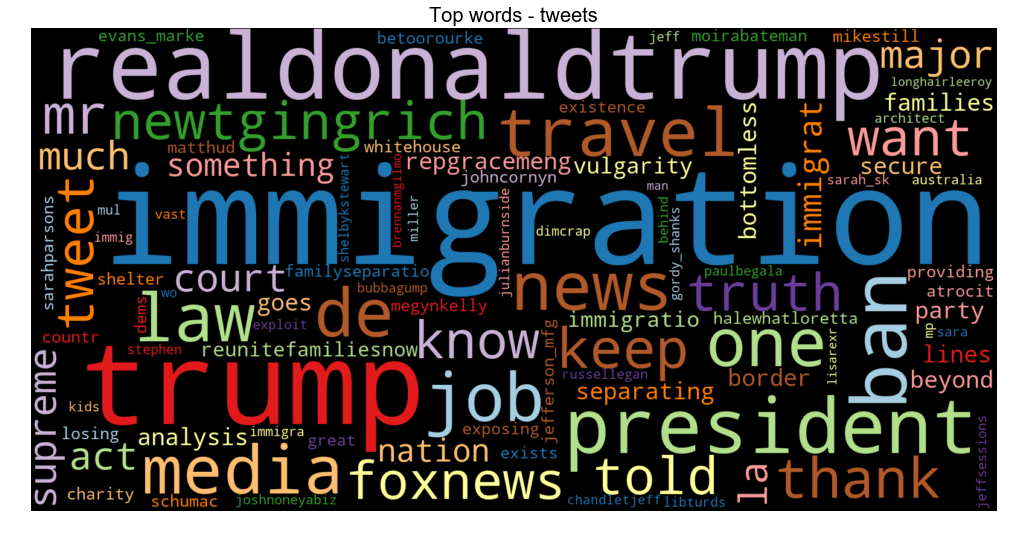

D:\Anaconda3\lib\json\encoder.py:199: DeprecationWarning:

Interpreting naive datetime as local 2018-06-28 20:54:13.175636. Please add timezone info to timestamps.



In [661]:
wordcloud = WordCloud(width=1600, height=800, random_state=1, max_words=100,colormap="Paired", background_color='black',)
wordcloud.generate(str(tweets_df['processed_tweets']))
# declare our figure 
plt.figure(figsize=(20,10))
plt.title("Top words - tweets", fontsize=20,color='black')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=10)
plt.show()

## 7) Sentiment Analysis - TextBlob 

In [396]:
def sentiment(x):
    sentiment = TextBlob(x)
    return sentiment.sentiment.polarity

In [397]:
tweets_df['sentiment'] = tweets_df['processed_tweets'].apply(sentiment)

D:\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [398]:
tweets_df[['cleaned_text','processed_tweets', 'sentiment']].head()

cleaned_text  \
0  RepGraceMeng realDonaldTrump Do your job Secur...   
1  This goes beyond party lines  Separating famil...   
2  Analysis  The bottomless vulgarity of Trump’s ...   
3  Immigration ReuniteFamiliesNow FamilySeparatio...   
4  mikestill megynkelly Immigration exists in all...   

                                    processed_tweets  sentiment  
0  repgracemeng realdonaldtrump job secure border...        0.4  
1  goes beyond party lines separating families be...        0.0  
2  analysis bottomless vulgarity trump immigratio...        0.0  
3  immigration reunitefamiliesnow familyseparatio...        0.0  
4  mikestill megynkelly immigration exists countr...        0.0

In [399]:
tweets_df['senti']=''
tweets_df['senti'][tweets_df['sentiment']>0] = 'positive'
tweets_df['senti'][tweets_df['sentiment']<0] = 'negative'
tweets_df['senti'][tweets_df['sentiment']==0] = 'neutral'

D:\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
D:\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
D:\Anaconda3\lib\site-packages\pandas\core\generic.py:7620: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
D:\Anaconda3\lib\site-pack

D:\Anaconda3\lib\site-packages\seaborn\categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


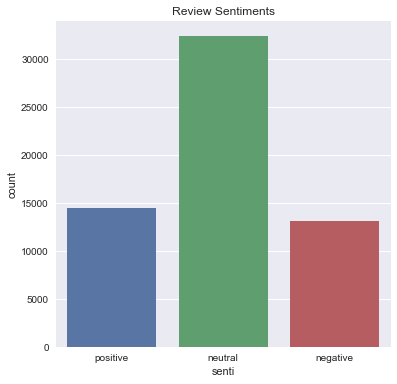

In [400]:
plt.figure(figsize=(6,6))
ax = sns.countplot(tweets_df['senti'])
plt.title('Review Sentiments');

In [402]:
tweets_df_pos = pd.DataFrame(tweets_df['processed_tweets'][tweets_df['senti']=='positive'])
tweets_df_neg = pd.DataFrame(tweets_df['processed_tweets'][tweets_df['senti']=='negative'])
tweets_df_neu = pd.DataFrame(tweets_df['processed_tweets'][tweets_df['senti']=='neutral'])

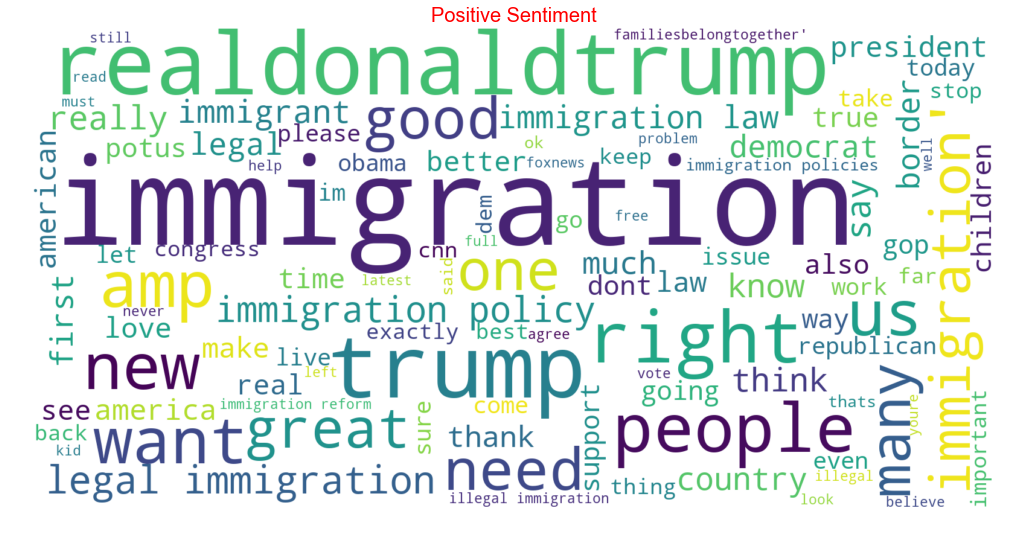

In [403]:
wordcloud = WordCloud(width=1600, height=800, random_state=1, max_words=100, background_color='white',)
wordcloud.generate(str(set(tweets_df_pos['processed_tweets'])))
# declare our figure 
plt.figure(figsize=(20,10))
plt.title("Positive Sentiment", fontsize=20,color='Red')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=10)
plt.show()

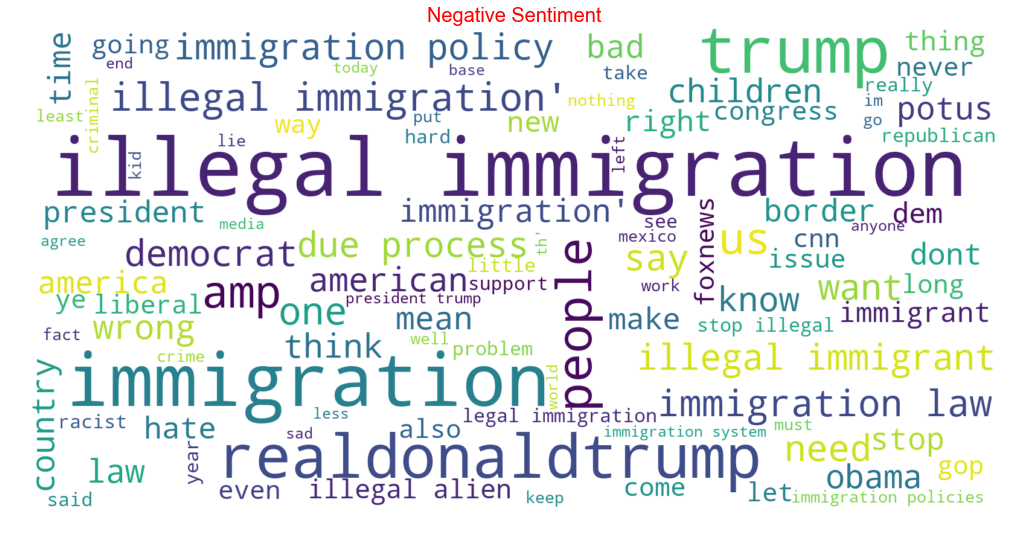

In [404]:
wordcloud = WordCloud(width=1600, height=800, random_state=1, max_words=100, background_color='white',)
wordcloud.generate(str(set(tweets_df_neg['processed_tweets'])))
# declare our figure 
plt.figure(figsize=(20,10))
plt.title("Negative Sentiment", fontsize=20,color='Red')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=10)
plt.show()

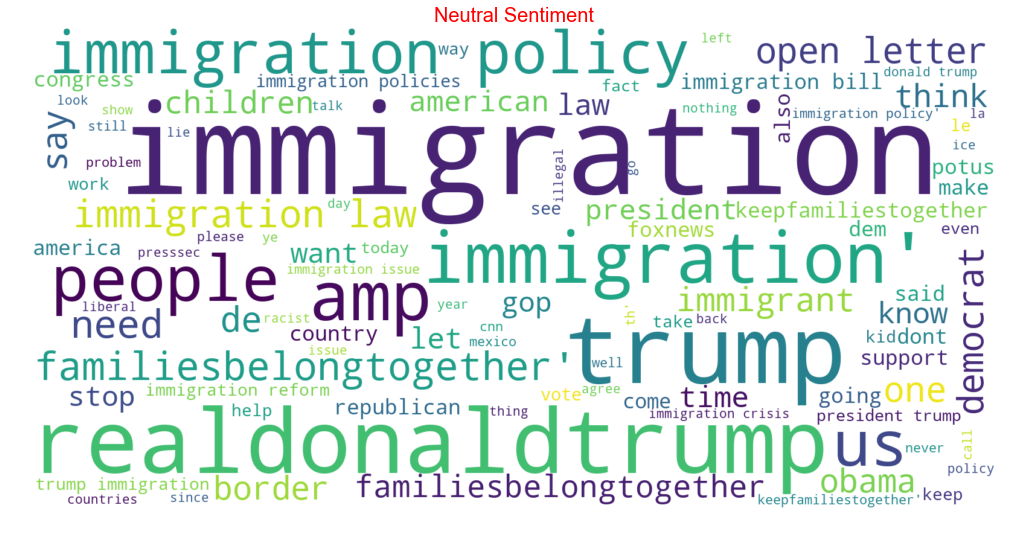

In [405]:
wordcloud = WordCloud(width=1600, height=800, random_state=1, max_words=100, background_color='white',)
wordcloud.generate(str(set(tweets_df_neu['processed_tweets'])))
# declare our figure 
plt.figure(figsize=(20,10))
plt.title("Neutral Sentiment", fontsize=20,color='Red')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=10)
plt.show()

## 7) Tweets sentiment using Vader Sentiment 

In [406]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [407]:
def print_sentiment_scores(tweets):
    vadersenti = analyser.polarity_scores(tweets)
    return pd.Series([vadersenti['pos'], vadersenti['neg'], vadersenti['neu'], vadersenti['compound']])

In [408]:
tweets_df.text[0], tweets_df.text[1]

('@RepGraceMeng @realDonaldTrump Do your job. Secure our borders and immigration reform!!!',
 'This goes beyond party lines.  Separating families betrays our values as Texans, Americans and fellow human beings.… https://t.co/r6UYRzfYM8')

In [409]:
print_sentiment_scores(tweets_df.text[0])

0    0.2470
1    0.0000
2    0.7530
3    0.5067
dtype: float64

In [410]:
tweets_df[['vadersenti_pos', 'vadersenti_neg', 'vadersenti_neu', 'vadersenti_compound']]  = tweets_df['text'].apply(print_sentiment_scores) 

D:\Anaconda3\lib\site-packages\pandas\core\frame.py:3137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [411]:
tweets_df[['text', 'senti', 'vadersenti_pos','vadersenti_neg', 'vadersenti_neu','vadersenti_compound']].head(2)

text     senti  \
0  @RepGraceMeng @realDonaldTrump Do your job. Se...  positive   
1  This goes beyond party lines.  Separating fami...   neutral   

   vadersenti_pos  vadersenti_neg  vadersenti_neu  vadersenti_compound  
0           0.247           0.000           0.753               0.5067  
1           0.226           0.146           0.628               0.2263

In [412]:
tweets_df['vader_senti'] = 'neutral'
tweets_df.loc[tweets_df['vadersenti_compound'] > 0.3 , 'vader_senti'] = 'positive'
tweets_df.loc[tweets_df['vadersenti_compound'] < 0.23 , 'vader_senti'] = 'negative'

tweets_df['vader_possentiment'] = 0
tweets_df.loc[tweets_df['vadersenti_compound'] > 0.3 , 'vader_possentiment'] = 1

tweets_df['vader_negsentiment'] = 0
tweets_df.loc[tweets_df['vadersenti_compound'] <0.23 , 'vader_negsentiment'] = 1

tweets_df['vader_neusentiment'] = 0
tweets_df.loc[(tweets_df['vadersenti_compound'] <=0.3) & (tweets_df['vadersenti_compound'] >=0.23) , 'vader_neusentiment'] = 1

D:\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
D:\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/index

In [413]:
tweets_df[['text', 'senti', 'vader_senti', 'vader_negsentiment', 'vader_possentiment','vadersenti_pos','vadersenti_neg', 'vadersenti_neu','vadersenti_compound']].head(2)

text     senti vader_senti  \
0  @RepGraceMeng @realDonaldTrump Do your job. Se...  positive    positive   
1  This goes beyond party lines.  Separating fami...   neutral    negative   

   vader_negsentiment  vader_possentiment  vadersenti_pos  vadersenti_neg  \
0                   0                   1           0.247           0.000   
1                   1                   0           0.226           0.146   

   vadersenti_neu  vadersenti_compound  
0           0.753               0.5067  
1           0.628               0.2263

In [414]:
print(tweets_df['text'][5])

@evans_marke @matthud59 @SarahParsons17 @Jefferson_MFG What on Earth is a “soft leave” ? No-one wants to damage our… https://t.co/FcPGm4zrzA


In [415]:
pd.set_option('display.max_columns', None)

In [416]:
print("Positive Tweets:\n")
print(list(tweets_df[tweets_df['vader_senti'] == 'positive'].processed_tweets)[:5])

print("\nNegative Tweets:\n")
print(list(tweets_df[tweets_df['vader_senti'] == 'negative'].processed_tweets)[:5])

print("\nNeutral Tweets:\n")
print(list(tweets_df[tweets_df['vader_senti'] == 'neutral'].processed_tweets)[:5])

Positive Tweets:

['repgracemeng realdonaldtrump job secure borders immigration reform', 'johncornyn existence charity providing shelter teens decades apparently without iss', 'whitehouse great job mr president dems losing black voters years dissing white voters mu', 'realdonaldtrump thank mr president 🇺 🇸 keep work maga ‘ people back taxcuts working', 'trump told one truth immigration media want know']

Negative Tweets:

['goes beyond party lines separating families betrays values texans americans fellow human beings', 'analysis bottomless vulgarity trump immigration politics', 'immigration reunitefamiliesnow familyseparation keepfamiliestogetheract', 'mikestill megynkelly immigration exists countries issue everywherewithout proper immig', 'evans_marke matthud sarahparsons jefferson_mfg earth soft leave ” noone wants damage']

Neutral Tweets:

['halewhatloretta schumac joshnoneyabiz vast multitude mobile wealthy enough pay th', 'hannahvh immilawwde karalynum immcivilrights melenaandra

In [612]:
print(tweets_df.vader_senti.value_counts())

negative    47124
positive    11385
neutral      1491
Name: vader_senti, dtype: int64


D:\Anaconda3\lib\json\encoder.py:199: DeprecationWarning:

Interpreting naive datetime as local 2018-06-28 16:09:52.191510. Please add timezone info to timestamps.



In [613]:
print(tweets_df.vader_senti.value_counts(normalize=True) * 100)

negative    78.540
positive    18.975
neutral      2.485
Name: vader_senti, dtype: float64


D:\Anaconda3\lib\json\encoder.py:199: DeprecationWarning:

Interpreting naive datetime as local 2018-06-28 16:09:58.823978. Please add timezone info to timestamps.



D:\Anaconda3\lib\site-packages\seaborn\categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


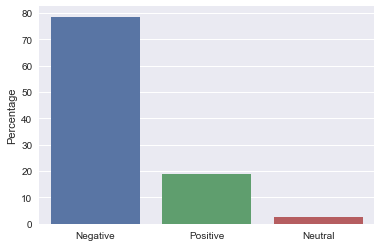

In [419]:
fig, ax = plt.subplots(figsize=(6, 4))

counts = tweets_df.vader_senti.value_counts(normalize=True) * 100

sns.barplot(x=counts.index, y=counts, ax=ax)

ax.set_xticklabels(['Negative', 'Positive', 'Neutral'])
ax.set_ylabel("Percentage")

plt.show()
    

## 7.1) Positive Words - VaderSentiment

In [420]:
def process_text(text):
    tokens = []
    for line in text:
        toks = tokenizer.tokenize(line)
        toks = [t.lower() for t in toks if t.lower() not in stopwords_list]
        tokens.extend(toks)
    
    return tokens

In [421]:
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
tokenizer=TweetTokenizer()
stopwords_list = stopwords.words('english') + punct + ['rt','via','...','…','’','—','—:']
pos_lines = list(tweets_df[tweets_df.vader_senti == 'positive'].processed_tweets)

pos_tokens = process_text(pos_lines)
pos_freq = nltk.FreqDist(pos_tokens)

pos_freq.most_common(20)

[('immigration', 5505),
 ('trump', 1216),
 ('realdonaldtrump', 1151),
 ('like', 832),
 ('us', 590),
 ('policy', 563),
 ('people', 559),
 ('amp', 523),
 ('good', 485),
 ('border', 484),
 ('president', 444),
 ('please', 420),
 ('help', 418),
 ('legal', 416),
 ('want', 412),
 ('support', 412),
 ('great', 394),
 ('children', 384),
 ('would', 379),
 ('country', 342)]

In [629]:
fdf = pd.DataFrame(pos_freq.most_common(20), columns=['Words', 'Freq'])

D:\Anaconda3\lib\json\encoder.py:199: DeprecationWarning:

Interpreting naive datetime as local 2018-06-28 19:10:52.920015. Please add timezone info to timestamps.



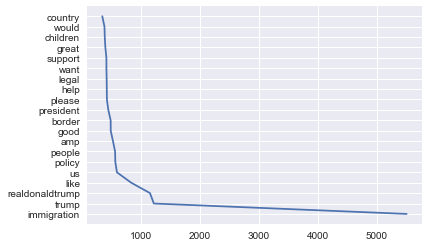

D:\Anaconda3\lib\json\encoder.py:199: DeprecationWarning:

Interpreting naive datetime as local 2018-06-28 19:15:36.207928. Please add timezone info to timestamps.



In [633]:
plt.plot( fdf.Freq, fdf.Words)

In [627]:
for x in pos_freq.most_common(10):
    print(x)

('immigration', 5505)
('trump', 1216)
('realdonaldtrump', 1151)
('like', 832)
('us', 590)
('policy', 563)
('people', 559)
('amp', 523)
('good', 485)
('border', 484)


D:\Anaconda3\lib\json\encoder.py:199: DeprecationWarning:

Interpreting naive datetime as local 2018-06-28 19:08:37.857403. Please add timezone info to timestamps.



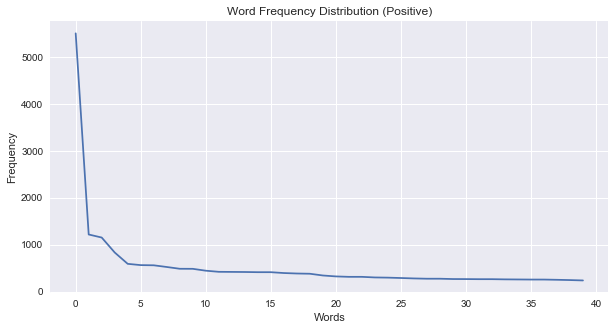

In [422]:
y_val = [x[1] for x in pos_freq.most_common(40)]

fig = plt.figure(figsize=(10,5))
plt.plot(y_val)

plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Word Frequency Distribution (Positive)")
plt.show()

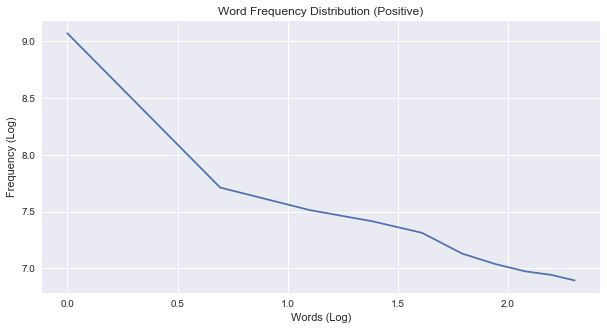

In [423]:
import math
y_final = []
for i, k, z, t in zip(y_val[0::4], y_val[1::4], y_val[2::4], y_val[3::4]):
    y_final.append(math.log(i + k + z + t))

x_val = [math.log(i + 1) for i in range(len(y_final))]

fig = plt.figure(figsize=(10,5))

plt.xlabel("Words (Log)")
plt.ylabel("Frequency (Log)")
plt.title("Word Frequency Distribution (Positive)")
plt.plot(x_val, y_final)
plt.show()

In [424]:
tweets_df_pos = pd.DataFrame(tweets_df[tweets_df.vader_senti == 'positive'].processed_tweets)
tweets_df_neg = pd.DataFrame(tweets_df[tweets_df.vader_senti == 'negative'].processed_tweets)
tweets_df_neu = pd.DataFrame(tweets_df[tweets_df.vader_senti == 'neutral'].processed_tweets)

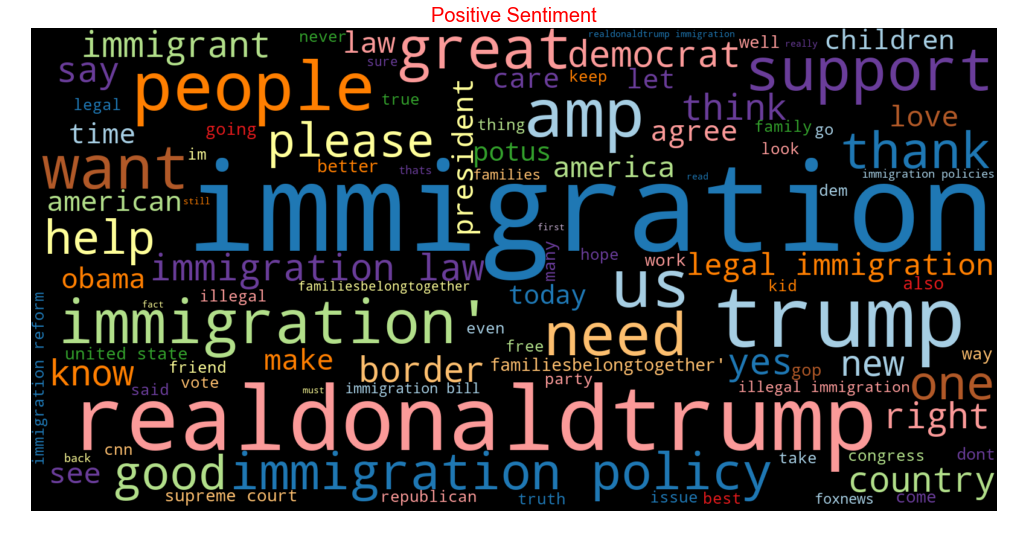

In [425]:
wordcloud = WordCloud(width=1600, height=800, random_state=1, max_words=100, colormap = 'Paired', background_color='black',)
wordcloud.generate(str(set(tweets_df_pos['processed_tweets'])))
# declare our figure 
plt.figure(figsize=(20,10))
plt.title("Positive Sentiment", fontsize=20,color='Red')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=10)
plt.show()

## 7.2) Negative Words - VaderSentiment

In [426]:
neg_lines = list(tweets_df[tweets_df.vader_senti == 'negative'].processed_tweets)

neg_tokens = process_text(neg_lines)
neg_freq = nltk.FreqDist(neg_tokens)

neg_freq.most_common(40)

[('immigration', 22001),
 ('trump', 7214),
 ('illegal', 3680),
 ('realdonaldtrump', 3453),
 ('border', 2259),
 ('us', 2164),
 ('policy', 2103),
 ('people', 1854),
 ('familiesbelongtogether', 1731),
 ('children', 1714),
 ('immigrants', 1620),
 ('amp', 1425),
 ('trumps', 1356),
 ('president', 1261),
 ('crisis', 1209),
 ('laws', 1198),
 ('law', 1180),
 ('says', 1124),
 ('obama', 1122),
 ('democrats', 1119),
 ('want', 1096),
 ('one', 1092),
 ('policies', 1052),
 ('stop', 1042),
 ('families', 1006),
 ('gop', 998),
 ('family', 977),
 ('dont', 967),
 ('get', 949),
 ('court', 941),
 ('potus', 910),
 ('”', 900),
 ('open', 894),
 ('need', 873),
 ('de', 866),
 ('‘', 855),
 ('cnn', 851),
 ('legal', 850),
 ('calls', 849),
 ('would', 838)]

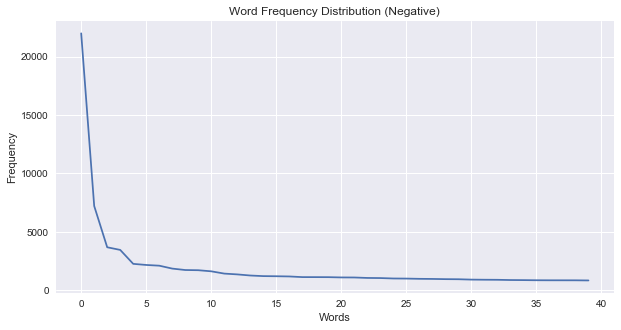

In [427]:
y_val = [x[1] for x in neg_freq.most_common(40)]

fig = plt.figure(figsize=(10,5))
plt.plot(y_val)

plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Word Frequency Distribution (Negative)")
plt.show()

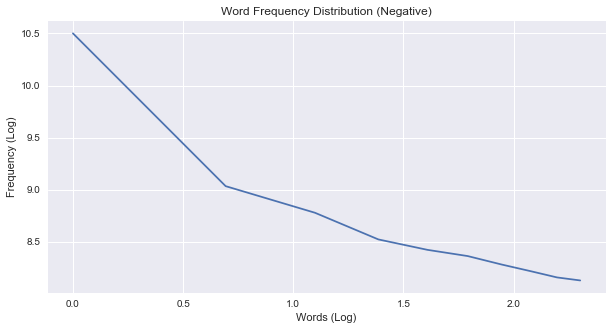

In [428]:
import math
y_final = []
for i, k, z, t in zip(y_val[0::4], y_val[1::4], y_val[2::4], y_val[3::4]):
    y_final.append(math.log(i + k + z + t))

x_val = [math.log(i + 1) for i in range(len(y_final))]

fig = plt.figure(figsize=(10,5))

plt.xlabel("Words (Log)")
plt.ylabel("Frequency (Log)")
plt.title("Word Frequency Distribution (Negative)")
plt.plot(x_val, y_final)
plt.show()

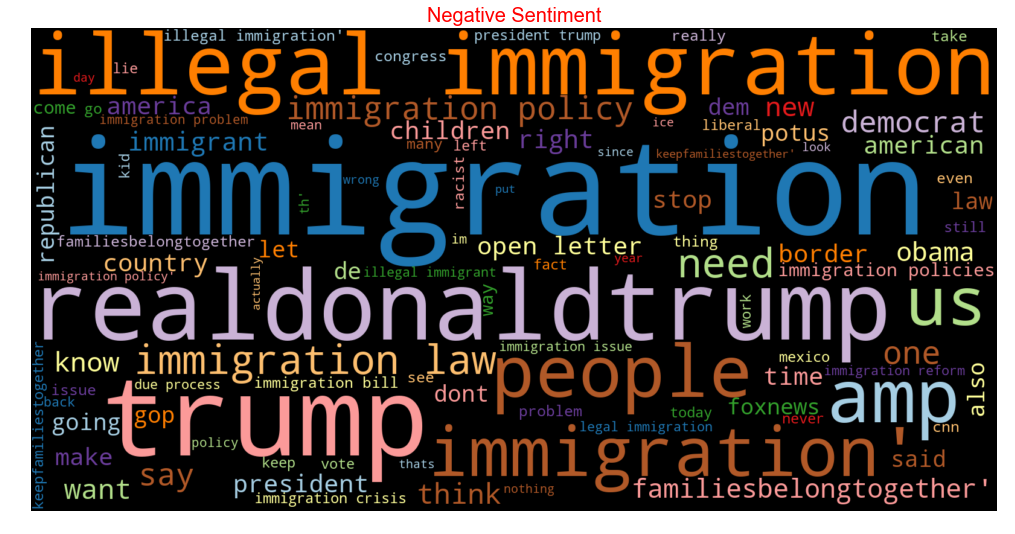

D:\Anaconda3\lib\json\encoder.py:199: DeprecationWarning:

Interpreting naive datetime as local 2018-06-28 16:13:34.882913. Please add timezone info to timestamps.



In [614]:
wordcloud = WordCloud(width=1600, height=800, random_state=1, max_words=100, colormap = 'Paired', background_color='black',)
wordcloud.generate(str(set(tweets_df_neg['processed_tweets'])))
# declare our figure 
plt.figure(figsize=(20,10))
plt.title("Negative Sentiment", fontsize=20,color='Red')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=10)
plt.show()

## 7.3) Neutral Words - VaderSentiment

In [430]:
neu_lines = list(tweets_df[tweets_df.vader_senti == 'neutral'].processed_tweets)

neu_tokens = process_text(neu_lines)
neu_freq = nltk.FreqDist(neu_tokens)

neu_freq.most_common(20)

[('immigration', 762),
 ('trump', 230),
 ('policy', 159),
 ('realdonaldtrump', 129),
 ('zero', 122),
 ('tolerance', 122),
 ('well', 106),
 ('us', 93),
 ('\x92', 90),
 ('want', 88),
 ('people', 66),
 ('join', 63),
 ('amp', 63),
 ('one', 60),
 ('say', 51),
 ('children', 50),
 ('may', 50),
 ('comprehensive', 48),
 ('know', 48),
 ('says', 48)]

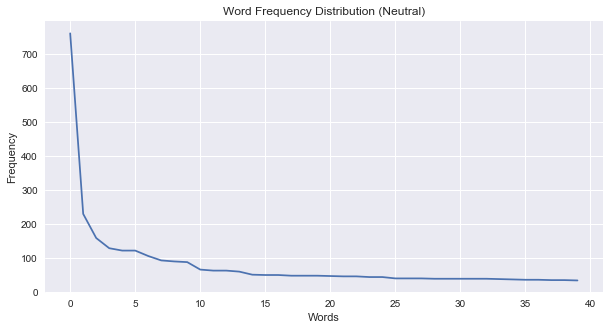

D:\Anaconda3\lib\json\encoder.py:199: DeprecationWarning:

Interpreting naive datetime as local 2018-06-28 16:23:11.339023. Please add timezone info to timestamps.



In [615]:
y_val = [x[1] for x in neu_freq.most_common(40)]

fig = plt.figure(figsize=(10,5))
plt.plot(y_val)

plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Word Frequency Distribution (Neutral)")
plt.show()

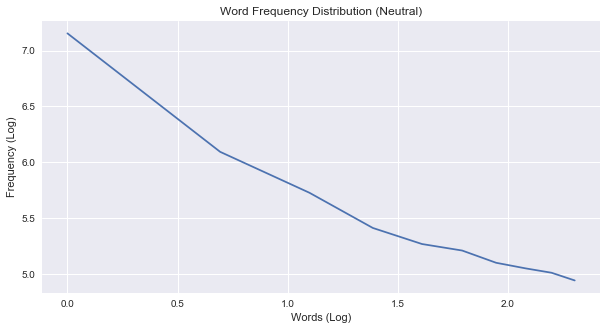

D:\Anaconda3\lib\json\encoder.py:199: DeprecationWarning:

Interpreting naive datetime as local 2018-06-28 16:23:16.512564. Please add timezone info to timestamps.



In [616]:
import math
y_final = []
for i, k, z, t in zip(y_val[0::4], y_val[1::4], y_val[2::4], y_val[3::4]):
    y_final.append(math.log(i + k + z + t))

x_val = [math.log(i + 1) for i in range(len(y_final))]

fig = plt.figure(figsize=(10,5))

plt.xlabel("Words (Log)")
plt.ylabel("Frequency (Log)")
plt.title("Word Frequency Distribution (Neutral)")
plt.plot(x_val, y_final)
plt.show()

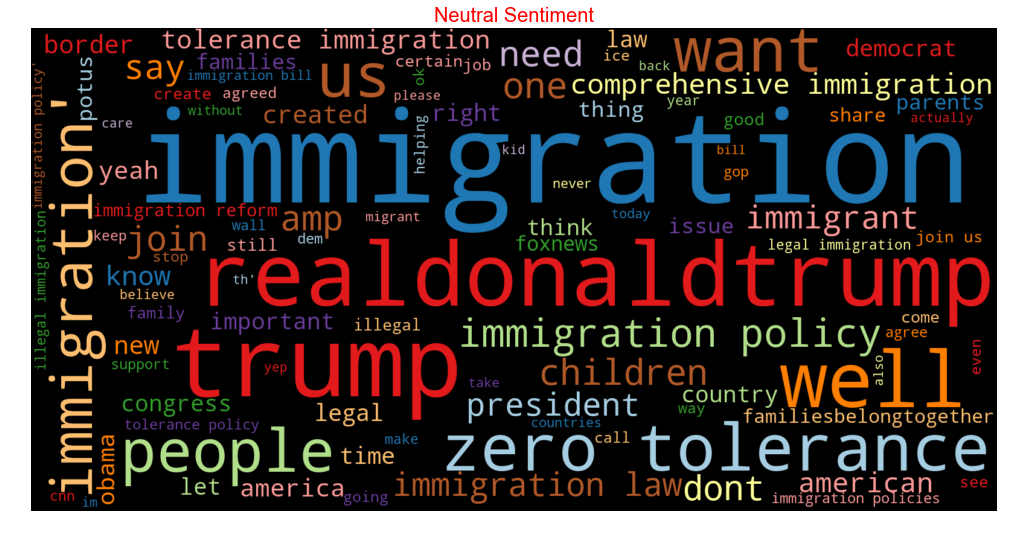

D:\Anaconda3\lib\json\encoder.py:199: DeprecationWarning:

Interpreting naive datetime as local 2018-06-28 16:23:24.992733. Please add timezone info to timestamps.



In [617]:
wordcloud = WordCloud(width=1600, height=800, random_state=1, max_words=100, colormap = 'Paired', background_color='black',)
wordcloud.generate(str(set(tweets_df_neu['processed_tweets'])))
# declare our figure 
plt.figure(figsize=(20,10))
plt.title("Neutral Sentiment", fontsize=20,color='Red')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=10)
plt.show()

## 8) Most favorited and retweeted tweet 

In [434]:
fav_max = np.max(tweets_df['favorite_count'])
rt_max  = np.max(tweets_df['retweet_count'])

fav = tweets_df[tweets_df.favorite_count == fav_max].index[0]
rt  = tweets_df[tweets_df.retweet_count == rt_max].index[0]

In [435]:
print("The tweet with more likes is: \n{}".format(tweets_df['text'][fav]))
print("Number of likes: {}".format(fav_max))
print("Tweeted by: {}".format(tweets_df['name'][fav]))

The tweet with more likes is: 
I just chatted w/ a Republican in #Oklahoma. He told me he’s a gun owner that believes in background checks &amp; said… https://t.co/H2SMoQk4Bf
Number of likes: 48263
Tweeted by: Rep. Eric Swalwell


In [436]:
print("The tweet with more retweets is: \n{}".format(tweets_df['text'][rt]))
print("Number of retweets: {}".format(rt_max))
print("Tweeted by: {}".format(tweets_df['name'][rt]))

The tweet with more retweets is: 
This is what Mr. Trump and Mr. Miller's immigration policy really looks like... https://t.co/hmWY1lSWSd
Number of retweets: 17921
Tweeted by: Michael Avenatti


## 9) Doing a time graph of favorite and retweet frequency

In [438]:
new_df= tweets_df[['id', 'source', 'created_at','text', 'processed_tweets', 'favorite_count','retweet_count','location','senti', 'vader_senti', 'vadersenti_pos', 'vadersenti_neg', 'vadersenti_neu', 'vadersenti_compound']]

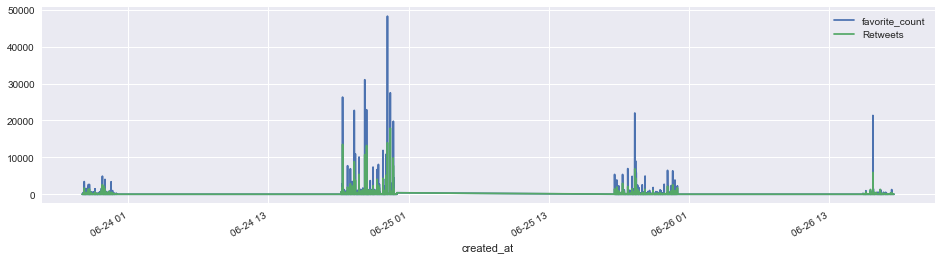

In [439]:
tfav = pd.Series(data=new_df['favorite_count'].values, index=new_df['created_at'])
tfav.plot(figsize=(16,4), label="favorite_count", legend=True)
tret = pd.Series(data=new_df['retweet_count'].values, index=new_df['created_at'])
tret.plot(figsize=(16,4), label="Retweets", legend=True)


## 10) Vader Sentiment and timeline

In [666]:
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

D:\Anaconda3\lib\json\encoder.py:199: DeprecationWarning:

Interpreting naive datetime as local 2018-07-05 16:14:15.127416. Please add timezone info to timestamps.



In [441]:
#Create new columns for year and month based on the shooting date
from datetime import datetime
tweets_df['created_at'] = pd.to_datetime(tweets_df['created_at'])
tweets_df['tweet_year'] = tweets_df['created_at'].dt.year
tweets_df['tweet_month'] = tweets_df['created_at'].dt.month
tweets_df['tweet_date'] = tweets_df['created_at'].dt.day
tweets_df['tweet_time'] = tweets_df['created_at'].dt.time

D:\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

D:\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [448]:
tweets_sentip = tweets_df[['tweet_year', 'tweet_month', 'tweet_date', 'vader_possentiment' ]].groupby(['tweet_date'], as_index=False).sum().sort_values(by='tweet_date', ascending=False)
tweets_sentin = tweets_df[['tweet_year', 'tweet_month', 'tweet_date', 'vader_negsentiment' ]].groupby(['tweet_date'], as_index=False).sum().sort_values(by='tweet_date', ascending=False)
tweets_sentinn = tweets_df[['tweet_year', 'tweet_month', 'tweet_date', 'vader_neusentiment' ]].groupby(['tweet_date'], as_index=False).sum().sort_values(by='tweet_date', ascending=False)
tweets_sentin

tweet_date  tweet_year  tweet_month  vader_negsentiment
3          26    20180000        60000                7768
2          25    40360000       120000               15614
1          24    40360000       120000               15643
0          23    20180000        60000                8099

In [667]:
tweeets_sentip = tweets_df[['tweet_year', 'tweet_month', 'tweet_date','tweet_time','vader_possentiment' ]].groupby(['tweet_time'], as_index=False).sum().sort_values(by='tweet_time', ascending=False)
tweeets_sentin = tweets_df[['tweet_year', 'tweet_month', 'tweet_date','tweet_time','vader_negsentiment' ]].groupby(['tweet_time'], as_index=False).sum().sort_values(by='tweet_time', ascending=False)
tweeets_sentinn = tweets_df[['tweet_year', 'tweet_month', 'tweet_date','tweet_time','vader_neusentiment' ]].groupby(['tweet_time'], as_index=False).sum().sort_values(by='tweet_time', ascending=False)

D:\Anaconda3\lib\json\encoder.py:199: DeprecationWarning:

Interpreting naive datetime as local 2018-07-05 16:14:29.305424. Please add timezone info to timestamps.



In [668]:
# Create traces
trace0 = go.Scatter(
    x = tweeets_sentip['tweet_date'],
    y = tweeets_sentip['vader_possentiment'],
    mode = 'lines',
    name = 'Vader +ve Sentiment'
)
trace1 = go.Scatter(
    x = tweeets_sentin['tweet_date'],
    y = tweeets_sentin['vader_negsentiment'],
    mode = 'lines',
    name = 'Vader -ve Sentiment'
)
trace2 = go.Scatter(
    x = tweeets_sentinn['tweet_date'],
    y = tweeets_sentinn['vader_neusentiment'],
    mode = 'lines',
    name = 'Vader neutral Sentiment'
)
layout = dict(
  title = 'Vader Sentiment'
)    
data = [trace0, trace1, trace2]
py.iplot({'data': data, 'layout': layout}, filename='Vader Sentiment')

D:\Anaconda3\lib\json\encoder.py:199: DeprecationWarning:

Interpreting naive datetime as local 2018-07-05 16:14:30.489596. Please add timezone info to timestamps.



# 11) Latent Dirichlet allocation
Generative statistical model that allows sets of observations to be explained by unobserved groups that explain why some parts of the data are similar. 

In [450]:
import spacy
from spacy.lang.en import English
parser = English()

In [454]:
import nltk
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer

In [456]:
en_stop = set(nltk.corpus.stopwords.words('english'))

In [451]:
def lda_tokenize(text):
    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        elif token.like_url:
            lda_tokens.append('URL')
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens

In [453]:
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma

In [455]:
def get_lemma2(word):
    return WordNetLemmatizer().lemmatize(word)

In [460]:
def prepare_text_for_lda(text):
    tokens = lda_tokenize(text)
    tokens = [token for token in tokens if len(token) > 4]
    tokens = [token for token in tokens if token not in en_stop]
    tokens = [get_lemma(token) for token in tokens]
    return tokens

In [498]:
tweets_df['lda'] = tweets_df['cleaned_text'].apply(prepare_text_for_lda)

In [500]:
tweets_df[['cleaned_text', 'lda']].head()

cleaned_text  \
0  RepGraceMeng realDonaldTrump Do your job Secur...   
1  This goes beyond party lines  Separating famil...   
2  Analysis  The bottomless vulgarity of Trump’s ...   
3  Immigration ReuniteFamiliesNow FamilySeparatio...   
4  mikestill megynkelly Immigration exists in all...   

                                                 lda  
0  [repgracemeng, realdonaldtrump, secure, border...  
1  [beyond, party, line, separate, family, betray...  
2  [analysis, bottomless, vulgarity, trump, immig...  
3  [immigration, reunitefamiliesnow, familysepara...  
4  [mikestill, megynkelly, immigration, exist, co...

tlist = []
for x in tweets_df.lda:
    for elem in x:
        tlist.append(x)

### 11.1) Words frequency

In [504]:
tokens_list = [elem for x in tweets_df.lda for elem in x]
len(tokens_list)

406056

In [635]:
Freq_df = pd.DataFrame(nltk.FreqDist(tokens_list).most_common(15), columns = ['Words', 'Frequency'])

D:\Anaconda3\lib\json\encoder.py:199: DeprecationWarning:

Interpreting naive datetime as local 2018-06-28 19:27:00.911021. Please add timezone info to timestamps.



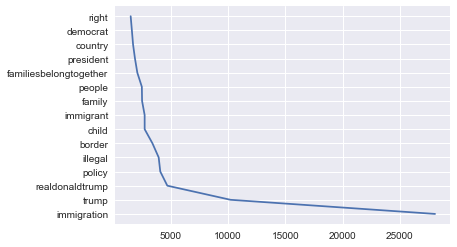

D:\Anaconda3\lib\json\encoder.py:199: DeprecationWarning:

Interpreting naive datetime as local 2018-06-28 19:27:02.018613. Please add timezone info to timestamps.



In [636]:
plt.plot( Freq_df.Frequency, Freq_df.Words)

### 11.2 Dictionary/Corpus of words - LDA

In [511]:
import gensim
from gensim import corpora
tweet_dict = corpora.Dictionary(tweets_df.lda)
tweet_corpus = [tweet_dict.doc2bow(tweetlda) for tweetlda in tweets_df.lda] #term document matrix

In [681]:
tweet_dict

D:\Anaconda3\lib\json\encoder.py:199: DeprecationWarning:

Interpreting naive datetime as local 2018-07-05 16:39:42.283566. Please add timezone info to timestamps.



In [685]:
len(list(tweet_dict.token2id.keys()))

49704

D:\Anaconda3\lib\json\encoder.py:199: DeprecationWarning:

Interpreting naive datetime as local 2018-07-05 16:41:48.790031. Please add timezone info to timestamps.



In [512]:
print(list(tweet_dict.token2id.keys())[:50])

['border', 'immigration', 'realdonaldtrump', 'reform', 'repgracemeng', 'secure', 'american', 'being', 'betray', 'beyond', 'family', 'fellow', 'human', 'line', 'party', 'separate', 'texan', 'values', 'analysis', 'bottomless', 'politics', 'trump', 'vulgarity', 'familyseparation', 'keepfamiliestogetheract', 'reunitefamiliesnow', 'country', 'everywherewithout', 'exist', 'immig', 'issue', 'megynkelly', 'mikestill', 'proper', 'damage', 'earth', 'evans_marke', 'jefferson_mfg', 'leave', 'matthud59', 'noone', 'sarahparsons17', 'want', 'apparently', 'charity', 'decade', 'existence', 'johncornyn', 'provide', 'shelter']


In [514]:
import pickle
pickle.dump(tweet_corpus, open('tweetcorpus.pkl', 'wb'))
tweet_dict.save('tweet_dict.gensim')

In [515]:
ldamodel = gensim.models.ldamodel.LdaModel(tweet_corpus, num_topics = 5, id2word=tweet_dict, passes=15)
ldamodel.save('model5.gensim')
topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.101*"immigration" + 0.047*"trump" + 0.028*"policy" + 0.018*"president"')
(1, '0.046*"immigration" + 0.028*"familiesbelongtogether" + 0.009*"letter" + 0.007*"issue"')
(2, '0.013*"immigration" + 0.012*"uphold" + 0.008*"asylum" + 0.006*"divide"')
(3, '0.043*"immigration" + 0.029*"child" + 0.020*"family" + 0.013*"separate"')
(4, '0.064*"immigration" + 0.028*"trump" + 0.023*"court" + 0.016*"illegal"')


In [516]:
ldamodel = gensim.models.ldamodel.LdaModel(tweet_corpus, num_topics = 3, id2word=tweet_dict, passes=15)
ldamodel.save('model3.gensim')
topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.107*"immigration" + 0.021*"trump" + 0.021*"policy" + 0.015*"border"')
(1, '0.020*"familiesbelongtogether" + 0.019*"country" + 0.009*"keepfamiliestogether" + 0.007*"letter"')
(2, '0.047*"immigration" + 0.033*"trump" + 0.016*"child" + 0.015*"family"')


In [517]:
ldamodel = gensim.models.ldamodel.LdaModel(tweet_corpus, num_topics = 10, id2word=tweet_dict, passes=15)
ldamodel.save('model10.gensim')
topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.056*"immigration" + 0.028*"trump" + 0.026*"crisis" + 0.024*"border"')
(1, '0.067*"immigration" + 0.030*"travel" + 0.016*"support" + 0.015*"problem"')
(2, '0.021*"immigration" + 0.018*"muslim" + 0.010*"rally" + 0.009*"wednesday"')
(3, '0.078*"immigration" + 0.024*"trump" + 0.021*"house" + 0.015*"policy"')
(4, '0.054*"trump" + 0.048*"child" + 0.044*"immigration" + 0.034*"family"')
(5, '0.077*"immigration" + 0.032*"trump" + 0.020*"congress" + 0.017*"uphold"')
(6, '0.048*"immigration" + 0.041*"familiesbelongtogether" + 0.017*"letter" + 0.016*"policy"')
(7, '0.018*"potus" + 0.016*"realdonaldtrump" + 0.015*"presssec" + 0.009*"marcorubio"')
(8, '0.085*"immigration" + 0.035*"illegal" + 0.026*"country" + 0.023*"american"')
(9, '0.096*"immigration" + 0.025*"court" + 0.024*"supreme" + 0.021*"trump"')


### 11.3) Visualizing Topics

In [519]:
dictionary = gensim.corpora.Dictionary.load('tweet_dict.gensim')
corpus = pickle.load(open('tweetcorpus.pkl', 'rb'))
lda = gensim.models.ldamodel.LdaModel.load('model5.gensim')

In [520]:
import pyLDAvis.gensim

D:\Anaconda3\lib\json\encoder.py:199: DeprecationWarning:

Interpreting naive datetime as local 2018-06-28 12:55:55.651197. Please add timezone info to timestamps.



In [664]:
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

D:\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False




D:\Anaconda3\lib\json\encoder.py:199: DeprecationWarning:

Interpreting naive datetime as local 2018-07-05 12:39:29.925979. Please add timezone info to timestamps.



In [522]:
lda_display = pyLDAvis.gensim.prepare(gensim.models.ldamodel.LdaModel.load('model10.gensim'), corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

D:\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False




D:\Anaconda3\lib\json\encoder.py:199: DeprecationWarning:

Interpreting naive datetime as local 2018-06-28 13:04:12.278560. Please add timezone info to timestamps.



## 12) Categorization of Tweets

In [588]:
tweets_df['protests'] = np.where(tweets_df['lda'].astype('str').str.contains('protest|demonstration|strike|fight', flags = re.IGNORECASE), 1, 0)
tweets_df['children'] = np.where(tweets_df['lda'].astype('str').str.contains('child|girl|boy|infant|baby|babies|family|families', flags = re.IGNORECASE), 1, 0)
tweets_df['government'] = np.where(tweets_df['lda'].astype('str').str.contains('politic|government|election|bill|trump|realdonaldtrump|policy', flags = re.IGNORECASE), 1, 0)
tweets_df['immigration'] = np.where(tweets_df['lda'].astype('str').str.contains('immigrant|immigration|immigrate|move|moving|travel|travelban|border|illegal', flags = re.IGNORECASE), 1, 0)

D:\Anaconda3\lib\json\encoder.py:199: DeprecationWarning:

Interpreting naive datetime as local 2018-06-28 15:28:11.011799. Please add timezone info to timestamps.



In [589]:
tweets_df.protests.sum(), tweets_df.government.sum(), tweets_df.children.sum(), tweets_df.immigration.sum()

(1500, 19428, 8946, 34120)

D:\Anaconda3\lib\json\encoder.py:199: DeprecationWarning:

Interpreting naive datetime as local 2018-06-28 15:28:16.479640. Please add timezone info to timestamps.



In [593]:
protest_df = tweets_df[['tweet_year', 'tweet_month', 'tweet_date', 'protests']].groupby(['tweet_date'], as_index=False).sum().sort_values(by='tweet_date', ascending=False)
govt_df = tweets_df[['tweet_year', 'tweet_month', 'tweet_date', 'government']].groupby(['tweet_date'], as_index=False).sum().sort_values(by='tweet_date', ascending=False)
children_df = tweets_df[['tweet_year', 'tweet_month', 'tweet_date', 'children']].groupby(['tweet_date'], as_index=False).sum().sort_values(by='tweet_date', ascending=False)
immi_df = tweets_df[['tweet_year', 'tweet_month', 'tweet_date', 'immigration']].groupby(['tweet_date'], as_index=False).sum().sort_values(by='tweet_date', ascending=False)

D:\Anaconda3\lib\json\encoder.py:199: DeprecationWarning:

Interpreting naive datetime as local 2018-06-28 15:37:17.508631. Please add timezone info to timestamps.



### 12.1) Tweet Categories and timeline

In [665]:
# Create traces
trace0 = go.Scatter(
    x = protest_df['tweet_date'],
    y = protest_df['protests'],
    mode = 'lines',
    name = 'Protests'
)
trace1 = go.Scatter(
    x = govt_df['tweet_date'],
    y = govt_df['government'],
    mode = 'lines',
    name = 'Government'
)
trace2 = go.Scatter(
    x = children_df['tweet_date'],
    y = children_df['children'],
    mode = 'lines',
    name = 'Children'
)
trace3 = go.Scatter(
    x = immi_df['tweet_date'],
    y = immi_df['immigration'],
    mode = 'lines',
    name = 'Immigration'
)
layout = dict(
  title = 'Tweets Categories'
)    
data = [trace0, trace1, trace2, trace3]
py.iplot({'data': data, 'layout': layout}, filename='Tweets Categories')

D:\Anaconda3\lib\json\encoder.py:199: DeprecationWarning:

Interpreting naive datetime as local 2018-07-05 16:13:44.835939. Please add timezone info to timestamps.



### 12.2) Vader Sentiment Vs Tweet categories and timeline

In [599]:
# Create traces
trace0 = go.Scatter(
    x = tweeets_sentip['tweet_date'],
    y = tweeets_sentip['vader_possentiment'],
    mode = 'lines',
    name = 'Vader +ve Sentiment'
)
trace1 = go.Scatter(
    x = tweeets_sentin['tweet_date'],
    y = tweeets_sentin['vader_negsentiment'],
    mode = 'lines',
    name = 'Vader -ve Sentiment'
)
trace2 = go.Scatter(
    x = tweeets_sentinn['tweet_date'],
    y = tweeets_sentinn['vader_neusentiment'],
    mode = 'lines',
    name = 'Vader neutral Sentiment'
)
trace3 = go.Scatter(
    x = protest_df['tweet_date'],
    y = protest_df['protests'],
    mode = 'lines',
    name = 'Protests'
)
trace4 = go.Scatter(
    x = govt_df['tweet_date'],
    y = govt_df['government'],
    mode = 'lines',
    name = 'Government'
)
trace5 = go.Scatter(
    x = children_df['tweet_date'],
    y = children_df['children'],
    mode = 'lines',
    name = 'Children'
)
trace6 = go.Scatter(
    x = immi_df['tweet_date'],
    y = immi_df['immigration'],
    mode = 'lines',
    name = 'Immigration'
)
layout = dict(
  title = 'Tweets Categories & Vader Sentiments'
)    
data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6]
py.iplot({'data': data, 'layout': layout}, filename='Tweets Categories')

D:\Anaconda3\lib\json\encoder.py:199: DeprecationWarning:

Interpreting naive datetime as local 2018-06-28 15:42:49.741808. Please add timezone info to timestamps.



## 13) Who tweeted more

In [611]:
top20_users = pd.DataFrame(tweets_df.screen_name.value_counts().head(20))
top20_users.head()

screen_name
openletterbot            563
m6mp3                    275
iam_immigration           81
genevieveisgg             74
gailmorris1974            56

D:\Anaconda3\lib\json\encoder.py:199: DeprecationWarning:

Interpreting naive datetime as local 2018-06-28 15:48:25.227295. Please add timezone info to timestamps.



## 14) Tweet Locations

In [642]:
locations = []
for location in tweets_df['location']:
    if location not in locations:
        locations.append(location)

D:\Anaconda3\lib\json\encoder.py:199: DeprecationWarning:

Interpreting naive datetime as local 2018-06-28 19:40:54.396830. Please add timezone info to timestamps.



In [651]:
tweets_df['location'].replace(['New York, NY', 'New York', 'Washington, D.C'], 
                            ['New York, USA', 'New York, USA' ,'Washington, DC'], inplace=True)

D:\Anaconda3\lib\json\encoder.py:199: DeprecationWarning:

Interpreting naive datetime as local 2018-06-28 19:47:30.808005. Please add timezone info to timestamps.



In [655]:
tweets_df['location'].replace(['New York City', 'Los Angeles', 'Los Angeles, CA' ,'California'], 
                            ['New York, USA', 'Los Angeles, USA', 'Los Angeles, USA' ,'California, USA'], inplace=True)

D:\Anaconda3\lib\json\encoder.py:199: DeprecationWarning:

Interpreting naive datetime as local 2018-06-28 19:49:06.122925. Please add timezone info to timestamps.



In [657]:
tweets_df['location'].replace(['New York, NY', 'New York', 'Washington, DC'], 
                            ['New York, USA', 'New York, USA' ,'Washington, D.C'], inplace=True)

D:\Anaconda3\lib\json\encoder.py:199: DeprecationWarning:

Interpreting naive datetime as local 2018-06-28 19:50:13.066290. Please add timezone info to timestamps.



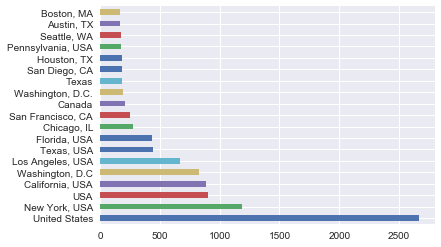

D:\Anaconda3\lib\json\encoder.py:199: DeprecationWarning:

Interpreting naive datetime as local 2018-06-28 19:50:14.773786. Please add timezone info to timestamps.



In [658]:
tweets_df['location'].value_counts()[1:20].plot(kind='barh')

## 15) Feature based classification of tweets
Text Classification is an example of supervised machine learning task since a labelled dataset containing text documents and their labels is used for train a classifier. An end-to-end text classification pipeline is composed of three main components:
1. Dataset Preparation: The first step is the Dataset Preparation step which includes the process of loading a dataset and performing basic pre-processing. The dataset is then splitted into train and validation sets.
2. Feature Engineering: The next step is the Feature Engineering in which the raw dataset is transformed into flat features which can be used in a machine learning model. This step also includes the process of creating new features from the existing data.
3. Model Training: The final step is the Model Building step in which a machine learning model is trained on a labelled dataset.

Here are the steps in training the classifier  
    - Extract features from the text  
    - Train the classifier with the features.  

### 15.1) Extracting features from tweets - LDA
We segment each tweet into words and count the number of times each word occurs in each tweet and finally assign each word an integer id. 
Each unique word corresponds to a feature (descriptive feature).

Inorder to do this, I need to first convert the tokens using LDA from list to string of words.

In [758]:
tweets_df['tokens'] = tweets_df['lda'].apply(', '.join)
tweets_df[['lda', 'tokens']].head(2)

lda  \
0                       [repgracemeng, realdonaldtrump, secure, border, immigration, reform]   
1  [beyond, party, line, separate, family, betray, values, texan, american, fellow, human...   

                                                                                      tokens  
0                         repgracemeng, realdonaldtrump, secure, border, immigration, reform  
1  beyond, party, line, separate, family, betray, values, texan, american, fellow, human,...

D:\Anaconda3\lib\json\encoder.py:199: DeprecationWarning:

Interpreting naive datetime as local 2018-07-05 23:49:30.573997. Please add timezone info to timestamps.



### 15.2) Split the train and test data 

In [759]:
from sklearn.model_selection import train_test_split

D:\Anaconda3\lib\json\encoder.py:199: DeprecationWarning:

Interpreting naive datetime as local 2018-07-05 23:50:11.170884. Please add timezone info to timestamps.



In [746]:
X = tweets_df['tokens']
y = tweets_df['vader_senti']

D:\Anaconda3\lib\json\encoder.py:199: DeprecationWarning:

Interpreting naive datetime as local 2018-07-05 23:38:29.297085. Please add timezone info to timestamps.



In [752]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

D:\Anaconda3\lib\json\encoder.py:199: DeprecationWarning:

Interpreting naive datetime as local 2018-07-05 23:41:36.712676. Please add timezone info to timestamps.



### 15.3) Convert a collection of text documents to a matrix of token counts using Countvectorizer

In [753]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
X_train_counts.shape

(42000, 38993)

D:\Anaconda3\lib\json\encoder.py:199: DeprecationWarning:

Interpreting naive datetime as local 2018-07-05 23:41:44.985279. Please add timezone info to timestamps.



##### count_vect.fit_transform(X_train.data) returns Term Document matrix. [n_samples, n_features].

### 15.4) TF-IDF Term Frequency times inverse document frequency

In [754]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(42000, 38993)

D:\Anaconda3\lib\json\encoder.py:199: DeprecationWarning:

Interpreting naive datetime as local 2018-07-05 23:41:52.041671. Please add timezone info to timestamps.



### 15.5) Naive Bayes classifier
Train the NB Classifier
Build a pipeline
Get the accuracy

In [762]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tfidf, y_train)

D:\Anaconda3\lib\json\encoder.py:199: DeprecationWarning:

Interpreting naive datetime as local 2018-07-05 23:55:37.401916. Please add timezone info to timestamps.



In [781]:
from sklearn.pipeline import Pipeline
text_nb = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', MultinomialNB()),
 ])
_ = text_nb.fit(X_train, y_train)

D:\Anaconda3\lib\json\encoder.py:199: DeprecationWarning:

Interpreting naive datetime as local 2018-07-06 00:10:25.755870. Please add timezone info to timestamps.



In [782]:
y_pred = text_nb.predict(X_test)
np.mean(y_pred == y_test)

0.7936111111111112

D:\Anaconda3\lib\json\encoder.py:199: DeprecationWarning:

Interpreting naive datetime as local 2018-07-06 00:10:28.032053. Please add timezone info to timestamps.



In [771]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))

[[14067     0    22]
 [  455     0    10]
 [ 3228     0   218]]


D:\Anaconda3\lib\json\encoder.py:199: DeprecationWarning:

Interpreting naive datetime as local 2018-07-06 00:01:11.380261. Please add timezone info to timestamps.



In [772]:
print(classification_report(y_test,y_pred))

D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



             precision    recall  f1-score   support

   negative       0.79      1.00      0.88     14089
    neutral       0.00      0.00      0.00       465
   positive       0.87      0.06      0.12      3446

avg / total       0.79      0.79      0.71     18000



D:\Anaconda3\lib\json\encoder.py:199: DeprecationWarning:

Interpreting naive datetime as local 2018-07-06 00:01:33.739014. Please add timezone info to timestamps.



### 15.6) SVM

In [777]:
from sklearn.linear_model import SGDClassifier

text_svm = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('svm', SGDClassifier(loss= 'hinge', penalty='l2', alpha=1e-3, n_iter=5, random_state=42)),
                    ])

_ = text_svm.fit(X_train, y_train)

D:\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning:

n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.

D:\Anaconda3\lib\json\encoder.py:199: DeprecationWarning:

Interpreting naive datetime as local 2018-07-06 00:07:19.903817. Please add timezone info to timestamps.



In [778]:
y_pred = text_svm.predict(X_test)
np.mean(y_pred == y_test)

0.7848333333333334

D:\Anaconda3\lib\json\encoder.py:199: DeprecationWarning:

Interpreting naive datetime as local 2018-07-06 00:08:55.978332. Please add timezone info to timestamps.



In [779]:
print(confusion_matrix(y_test,y_pred))

[[14089     0     0]
 [  465     0     0]
 [ 3408     0    38]]


D:\Anaconda3\lib\json\encoder.py:199: DeprecationWarning:

Interpreting naive datetime as local 2018-07-06 00:09:11.388743. Please add timezone info to timestamps.



In [780]:
print(classification_report(y_test,y_pred))

D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



             precision    recall  f1-score   support

   negative       0.78      1.00      0.88     14089
    neutral       0.00      0.00      0.00       465
   positive       1.00      0.01      0.02      3446

avg / total       0.81      0.78      0.69     18000



D:\Anaconda3\lib\json\encoder.py:199: DeprecationWarning:

Interpreting naive datetime as local 2018-07-06 00:09:15.542496. Please add timezone info to timestamps.



### 15.7) Grid Search 

In [783]:
from sklearn.model_selection import GridSearchCV
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
               'tfidf__use_idf': (True, False),
               'clf__alpha': (1e-2, 1e-3),
 }

D:\Anaconda3\lib\json\encoder.py:199: DeprecationWarning:

Interpreting naive datetime as local 2018-07-06 00:11:15.157758. Please add timezone info to timestamps.



In [784]:
text_gs_nb = GridSearchCV(text_nb, parameters, n_jobs=-1)
text_gs_nb = text_gs.fit(X_train, y_train)

D:\Anaconda3\lib\json\encoder.py:199: DeprecationWarning:

Interpreting naive datetime as local 2018-07-06 00:12:21.806373. Please add timezone info to timestamps.



In [787]:
text_gs_nb.best_score_, text_gs_nb.best_params_

(0.824595238095238,
 {'clf__alpha': 0.01, 'tfidf__use_idf': False, 'vect__ngram_range': (1, 2)})

D:\Anaconda3\lib\json\encoder.py:199: DeprecationWarning:

Interpreting naive datetime as local 2018-07-06 00:14:03.452846. Please add timezone info to timestamps.



In [790]:
from sklearn.model_selection import GridSearchCV
parameters_svm = {'vect__ngram_range': [(1, 1), (1, 2)],
               'tfidf__use_idf': (True, False),
               'svm__alpha': (1e-2, 1e-3),
 }
text_gs_svm = GridSearchCV(text_svm, parameters_svm, n_jobs=-1)
text_gs_svm = text_gs_svm.fit(X_train, y_train)

D:\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning:

n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.

D:\Anaconda3\lib\json\encoder.py:199: DeprecationWarning:

Interpreting naive datetime as local 2018-07-06 00:17:10.756451. Please add timezone info to timestamps.



In [791]:
text_gs_svm.best_score_, text_gs_svm.best_params_

(0.7885714285714286,
 {'svm__alpha': 0.001, 'tfidf__use_idf': False, 'vect__ngram_range': (1, 1)})

D:\Anaconda3\lib\json\encoder.py:199: DeprecationWarning:

Interpreting naive datetime as local 2018-07-06 00:18:17.603402. Please add timezone info to timestamps.

